<a href="https://colab.research.google.com/github/pythonkvs/seminars/blob/main/%D0%AD%D1%84%D1%84%D0%B5%D0%BA%D1%82%D0%B8%D0%B2%D0%BD%D0%BE%D1%81%D1%82%D1%8C_%D0%BA%D0%BE%D0%B4%D0%B0_%D0%BF%D0%BE%D1%82%D0%BE%D0%BA%D0%B8_%D0%BF%D1%80%D0%BE%D1%86%D0%B5%D1%81%D1%81%D1%8B/%D0%9F%D0%BE%D1%82%D0%BE%D0%BA%D0%B8_%D0%BF%D1%80%D0%BE%D1%86%D0%B5%D1%81%D1%81%D1%8B_21_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://compscicenter.ru/courses/python/2015-autumn/classes/1562/

# Многопоточность и GIL

## Процесс

* Процесс — запущенная программа.
* У каждого процесса есть изолированное от других
процессов состояние:
    * виртуальное адресное пространство,
    * указатель на исполняемую инструкцию,
    * стек вызовов,
    * системные ресурсы, например, открытые файловые
дескрипторы.
* Процессы удобны для одновременного выполнения
нескольких задач.
* Альтернативный способ: делегировать каждую задачу на
выполнение потоку.

## Поток

* Поток похож на процесс тем, что его исполнение
происходит независимо от других потоков (и процессов).
* В отличие от процесса поток исполняется внутри процесса
и разделяет с ним адресное пространство и системные
ресурсы.
* Потоки удобны для одновременного выполнения
нескольких задач, которым требуется доступ к
разделяемому состоянию.
* Совместным выполнением нескольких процессов и
потоков управляет операционная система, поочерёдно
разрешая каждому процессу или потоку использовать
сколько-то циклов процессора.

# Модуль `threading`

* Поток в Python — это системный поток, то есть его
выполнением управляет не интерпретатор, а
операционная система.
* Создать поток можно с помощью класса `Thread` из модуля
стандартной библиотеки `threading`.
* Пример:

In [57]:
import time
from threading import Thread


def countdown(n):
    for i in range(n):
        print(n - i - 1, "left")
        time.sleep(1)

t = Thread(target=countdown, args=(3, ))
t.start()
# t.join()

2 left


## Наследование класса `Thread`

Альтернативный способ создания потока — наследование:

In [2]:
class CountdownThread(Thread):
    def __init__(self, n):
        super().__init__()
        self.n = n

    def run(self): # вызывается методом start.
        for i in range(self.n):
            print(self.n - i - 1, "left")
            time.sleep(1)


t = CountdownThread(3)
t.start()

2

Минус такого подхода в том, что он ограничивает
переиспользование кода: функциональность класса
`CountdownThread` можно использовать только в отдельном
потоке.

## Имя и идентификатор потока

* При создании потоку можно указать имя. По умолчанию
оно `"Thread-N"`:

In [3]:
Thread().name

 left


'Thread-13'

In [4]:
Thread(name="NumberCruncher").name

'NumberCruncher'

* У каждого активного потока есть идентификатор —
неотрицательное число, уникальное для всех активных
потоков.

In [5]:
t = Thread()
t.start()
t.ident

140088184887040

## Присоединение потоков

* Метод `join` позволяет дождаться завершения потока.
    * Выполнение вызывающего потока приостановится, пока не
завершится поток `t`.
    * Повторные вызовы метода `join` не имеют эффекта.
    * Пример:

In [6]:
t = Thread(target=time.sleep, args=(5, ))
t.start()
t.join() # блокируется на 5 секунд
t.join() # выполняется моментально

0 left
1 left
0 left


* Проверить, выполняется ли поток, можно с помощью
метода `is_alive`:

In [7]:
t = Thread(target=time.sleep, args=(5, ))
t.start()
t.is_alive()

True

In [8]:
t.is_alive() # через 5 секунд

True

## Потоки и демоны

* Демон — это поток, созданный с аргументом `daemon=True`:

In [9]:
t = Thread(target=time.sleep, args=(5, ), daemon=True)
t.start()
t.daemon

True

* Отличие потока-демона от обычного потока в том,
потоки-демоны **автоматически** уничтожаются при выходе
из интерпретатора.
* Уничтожение потока-демона не подразумевает процедуру
финализации, поэтому следует быть аккуратным при
использовании демонов для задач, работающих с
ресурсами.

## Завершение потоков

* В Python нет встроенного механизма завершения
потоков — это не случайность, а осознанное решение
разработчиков языка.
* Корректное завершение потока часто связано с
освобождением ресурсов, например:
    * поток может работать с файлом, дескриптор которого
нужно закрыть,
    * или захватить примитив синхронизации.
* Для завершения потока обычно используют флаг:

In [10]:
class Task:
    def __init__(self):
        self._running = True
    def terminate(self):
        self._running = False
    def run(self, n):
        while self._running:
            ...

## Примитивы синхронизации: мьютексы и семафоры

Набор примитивов синхронизации в модуле `threading`
стандартный:
* `Lock` — обычный мьютекс, используется для обеспечения
эксклюзивного доступа к разделяемому состоянию.
* `RLock` — рекурсивный мьютекс, разрешающий потоку,
владеющему мьютексом, захватить мьютекс более одного
раза.
* `Semaphore` — вариация мьютекса, которая разрешает
захватить себя не более фиксированного числа раз.
* `BoundedSemaphore` — семафор, который следит за тем, что
его захватили и отпустили одинаковое количество раз.

## Потокобезопасный ~~и медленный~~ счётчик

* Все примитивы синхронизации реализуют единый
интерфейс:
    * метод `acquire` захватывает примитив синхронизации,
    * а метод `release` отпускает его.
* Пример:

In [11]:
class SharedCounter:
    def __init__(self, value):
        self._value = value
        self._lock = Lock()
    def increment(self, delta=1):
        self._lock.acquire()
        self._value += delta
        self._lock.release()

    def get(self):
        return self._value

## Примитивы синхронизации: грязные подробности

* Все мьютексы и семафоры в модуле `threading`
реализованы “с нуля” в терминах примитивного бинарного
семафора

```
typedef struct {
    char     locked;
    cond_t   lock_released;
    mutex_t  mut;
} lock_t;
```

* Мьютекс `mut` используется только для синхронизации
доступа к полю `locked`.
* Забавное следствие: для мьютекса в Python не определено
понятие владеющего потока, то есть поток может отпустить
мьютекс, не захваченный им.

## Примитивы синхронизации: грязный пример

In [12]:
from threading import Lock
done = Lock()
def idle_release():
    print("Running!")
    time.sleep(15)
    done.release()

done.acquire()

True

In [13]:
Thread(target=idle_release).start()

Running!

In [14]:
done.acquire() and print("WAT?")


WAT?


## Примитивы синхронизации: условные переменные

* `Condition` используется для отправки сигналов между
потоками.
* Метод `wait` блокирует вызывающий поток, пока какой-то
другой поток не вызовет метод `notify` или `notify_all`.


In [15]:
from collections import deque
from threading import Condition


q = deque()
is_empty = Condition()

def producer():
    while True:
        is_empty.acquire()
        q.append([])
        is_empty.notify()
        is_empty.release()

def consumer():
    while True:
        is_empty.acquire()
        while not q: # !
            is_empty.wait()
        tmp = q.popleft()
        is_empty.release()

## Пример: функция `follow`

Функция `follow` читает сообщения из переданного ей
соединения и кладёт их в очередь на обработку.

In [16]:
def follow(connection, connection_lock, q):
    try:
        while True:
            connection_lock.acquire()
            message = connection.read_message()
            connection_lock.release()
            q.put(message)
    except InvalidMessage:
        follow(connection, connection_lock, q)
        
follower = Thread(target=follow, args=...)
follower.start()

## Примитивы синхронизации и менеджеры контекста

Чтобы минимизировать ошибки при использовании методов
`acquire` и `release`, все примитивы синхронизации поддерживают
протокол менеджеров контекста.

In [17]:
def follow(connection, connection_lock, q):
    try:
        while True:
            with connection_lock:
                message = connection.read_message()
            q.put(message)
    except IOError:
        follow(connection, connection_lock, q)

Exception in thread Thread-19:
Traceback (most recent call last):
  File "/usr/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
TypeError: follow() argument after * must be an iterable, not ellipsis



# Модуль `queue`

* Модуль queue реализует несколько потокобезопасных
очередей:
    * `Queue` — FIFO очередь,
    * `LifoQueue` — LIFO очередь aka стек,
    * `PriorityQueue` — очередь, элементы которой — пары вида
    (`priority`, `item`).
* Никаких особых изысков в реализации очередей нет: все
методы, изменяющие состояние, работают “внутри”
мьютекса.
* Класс `Queue` использует в качестве контейнера `deque`, а
классы `LifoQueue` и `PriorityQueue` — список.

## Пример работы с очередью

In [18]:
def worker(q):
    while True:
        item = q.get()      # блокирующе ожидает следующий
        do_something(item)  # элемент
        q.task_done()       # уведомляет очередь о выполнении
                            # задания

In [19]:
def master(q):
    for item in source():
        q.put(item)

    # блокирующе ожидает, пока все элементы очереди
    # не будут обработаны
    q.join()

# Модуль `futures`

## Модуль `futures`: исполнители

* Модуль `concurrent.futures` содержит абстрактный класс
`Executor` и его реализацию в виде пула потоков —
`ThreadPoolExecutor`.
* Интерфейс исполнителя состоит всего из трёх методов:

In [20]:
from concurrent.futures import ThreadPoolExecutor

executor = ThreadPoolExecutor(max_workers=4)
executor.submit(print, "Hello, world!")

Hello, world!

<Future at 0x7f68d1fca950 state=running>

In [21]:
list(executor.map(print, ["Knock?", "Knock!"]))

Knock?
Knock!


[None, None]

In [22]:
executor.shutdown()

Исполнители поддерживают протокол менеджеров
контекста:

In [23]:
with ThreadPoolExecutor(max_workers=4) as executor:
    pass

## Модуль `futures`: будущее

* Метод `Executor.submit` возвращает экземпляр класса
`Future`, инкапсулирующего асинхронные вычисления.
* Что можно делать с `Future`?

In [24]:
with ThreadPoolExecutor(max_workers=4) as executor:
    f = executor.submit(sorted, [4, 3, 1, 2])

Поинтересоваться состоянием вычисления:

In [25]:
f.running(), f.done(), f.cancelled()

(False, True, False)

Блокирующе подождать результата вычисления:

In [26]:
print(f.result())

[1, 2, 3, 4]


In [27]:
print(f.exception())

None


Добавить функцию, которая будет вызвана после
завершения вычисления:

In [28]:
f.add_done_callback(print)

<Future at 0x7f68d5a69690 state=finished returned list>


## Пример использования модуля `futures: integrate`

In [29]:
import math
def integrate(f, a, b, *, n_iter=1000):
    acc = 0
    step = (b - a) / n_iter
    for i in range(n_iter):
        acc += f(a + i * step) * step
    return acc

In [30]:
integrate(math.cos, 0, math.pi / 2)

1.0007851925466296

In [31]:
integrate(math.sin, 0, math.pi)

1.9999983550656637

## Пример использования модуля `futures: integrate_async`

In [32]:
from functools import partial
from concurrent.futures import as_completed
def integrate_async(f, a, b, *, n_jobs, n_iter=1000):
    executor = ThreadPoolExecutor(max_workers=n_jobs)
    spawn = partial(executor.submit, integrate, f,
                    n_iter=n_iter // n_jobs)
    
    step = (b - a) / n_jobs
    fs = [spawn(a + i * step, a + (i + 1) * step)
          for i in range(n_jobs)]
    return sum(f.result() for f in as_completed(fs))

In [33]:
integrate_async(math.cos, 0, math.pi / 2, n_jobs=2)

1.0007851925466305

In [34]:
integrate_async(math.sin, 0, math.pi, n_jobs=2)

1.9999983550656624

## Инфраструктура для многопоточного программирования в Python

* Модули `threading`, `queue` и `concurrent.futures` реализуют
привычные инструменты для параллельного программирования на
Python.
* Мы обсудили:
    * потоки,
    * мьютексы и семафоры,
    * события и условные переменные,
    * очереди,
    * пулы потоков.

# Параллелизм и конкурентность

## Потоки и производительность

Сравним производительность последовательной и
параллельной версий функции `integrate` с помощью
“магической” команды `timeit`:

In [35]:
%%timeit -n100
integrate(math.cos, 0, math.pi / 2,
          n_iter=10**6)

100 loops, best of 5: 201 ms per loop


In [36]:
%%timeit -n100
integrate_async(math.cos, 0, math.pi / 2,
          n_iter=10**6,
          n_jobs=2)

100 loops, best of 5: 191 ms per loop


In [37]:
%%timeit -n100
integrate_async(math.cos, 0, math.pi / 2,
          n_iter=10**6,
          n_jobs=4)

100 loops, best of 5: 195 ms per loop


## Что такое GIL?

* GIL (global interpreter lock) — это мьютекс, который
гарантирует, что в каждый момент времени только один
поток имеет доступ к внутреннему состоянию
интерпретатора.
* Python C API позволяет отпустить GIL, но это безопасно
только при работе с объектами, не зависящими от
интерпретатора Python.
* Например, все операции ввода/вывода в CPython
отпускают GIL:
```
// ...
Py_BEGIN_ALLOW_THREADS
err = close(fd);
if (err < 0)
    save_errno = errno;
Py_END_ALLOW_THREADS
// ...
```

## Параллелизм и конкурентность

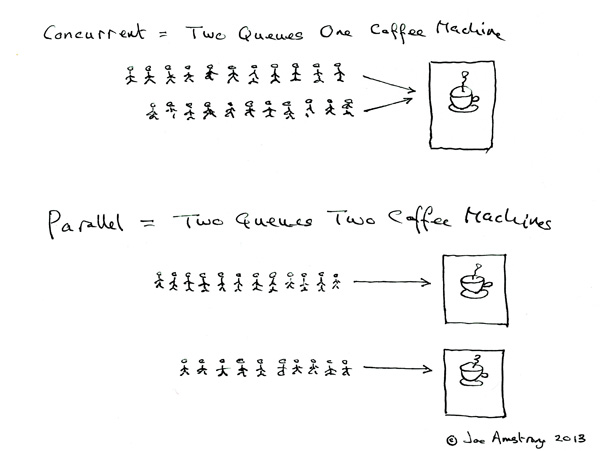

## GIL — это плохо?

* Ответ зависит от задачи.
* Наличие GIL делает невозможным использование потоков
в Python для параллелизма: несколько потоков не
ускоряют, а иногда даже замедляют работу программы.
* GIL не мешает использовать потоки для конкурентности
при работе с вводом/выводом, например:


In [ ]:
from urllib.request import urlretrieve
with ThreadPoolExecutor(max_workers=4) as executor:
    with open("urls.txt", "w") as handle:
        for url in handle:
            executor.submit(urlretrieve, url)

## Модуль asyncio

In [ ]:
import asyncio

async def echo(source, target):
    while True:
        line = await source.readline() # ->
        if not line:
            break
        target.write(line)

loop = asyncio.get_event_loop()
server = asyncio.start_server(echo, port=8080)
loop.create_task(server)

try:
    loop.run_forever()
finally:
    server.close()
    loop.close()

## С и Cython — средство от GIL

In [40]:
%load_ext Cython

In [41]:
%%cython
from libc.math cimport cos
def integrate(f, double a, double b, long n_iter):
    #         ^ мы используем C-версию функции
    cdef double acc = 0
    cdef double step = (b - a) / n_iter
    cdef long i
    with nogil:
        for i in range(n_iter):
            acc += cos(a + i * step) * step
    return acc

In [42]:
%%timeit -n100
integrate_async(math.cos, 0, math.pi / 2,
                n_iter=10**6, n_jobs=2)

100 loops, best of 5: 15.3 ms per loop


In [43]:
%%timeit -n100
integrate_async(math.cos, 0, math.pi / 2,
                n_iter=10**6, n_jobs=4)

100 loops, best of 5: 15.5 ms per loop


# Модуль `multiprocessing`

## Процессы — ещё одно средство от GIL

* Можно использовать вместо потоков процессы.
* У каждого процесса будет свой GIL, но он не помешает им
работать параллельно.
* За работу с процессами в Python отвечает модуль
`multiprocessing`:

In [44]:
import multiprocessing as mp
p = mp.Process(target=countdown, args=(5, ))
p.start()

4 left


In [45]:
p.name, p.pid

('Process-1', 18641)

In [46]:
p.daemon

False

In [47]:
p.join()
p.exitcode

0

## Модуль `multiprocessing`

* Модуль реализует базовые примитивы синхронизации:
мьютексы, семафоры, условные переменные.
* Для организации взаимодействия между процессами
можно использовать `Pipe` — основанное на сокете
соединение между двумя процессами:

In [48]:
def ponger(conn):
    conn.send("pong")

parent_conn, child_conn = mp.Pipe()
p = mp.Process(target=ponger,
               args=(child_conn, ))

p.start()
parent_conn.recv()

'pong'

In [49]:
p.join()

* Альтернативно два и более процессов можно соединить
через очередь `Queue` или `JoinableQueue` — аналоги
потокобезопасных очередей из модуля `queue`.

## Процессы и производительность

Реализация функции `integrate_async` на основе пула потоков
работала 191 мс, попробуем использовать пул процессов:

In [50]:
from concurrent.futures import ProcessPoolExecutor, as_completed

In [51]:
def integrate_async(f, a, b, *, n_jobs, n_iter=1000):
    executor = ProcessPoolExecutor(
    max_workers=n_jobs)
    spawn = partial(executor.submit, integrate, f,
                    n_iter=n_iter // n_jobs)

    step = (b - a) / n_jobs
    fs = [spawn(a + i * step, a + (i + 1) * step)
          for i in range(n_jobs)]
    return sum(f.result() for f in as_completed(fs))

In [52]:
%%timeit -n100
integrate_async(math.cos, 0, math.pi / 2,
                n_iter=10**6, n_jobs=4)

100 loops, best of 5: 126 ms per loop


## Пакет `joblib`

Пакет `joblib` реализует параллельный аналог цикла `for`,
который удобно использовать для параллельного
выполнения независимых задач.

In [53]:
from joblib import Parallel, delayed

def integrate_async(f, a, b, *, n_jobs, n_iter=1000,
                    backend=None):
    step = (b - a) / n_jobs
    with Parallel(n_jobs=n_jobs,
                  backend=backend) as parallel:
        fs = (delayed(integrate)(a + i * step,
                                 a + (i + 1) * step,
                                 n_iter=n_iter // n_jobs)
            for i in range(n_jobs))
        return sum(parallel(fs))

* В качестве значения аргумента `backend` можно указать
"threading" или "multiprocessing".

## Параллелизм и конкурентность: резюме

* GIL — это глобальный мьютекс, который ограничивает
возможности использования потоков для параллелизма в
программах на СPython.
* Для программ, использующих, в основном, операции
ввода/вывода, GIL не страшен: в CPython эти операции
отпускают GIL.
* Для программ, нуждающихся в параллелизме, для
повышения производительности есть варианты:
    * писать критическую функциональность на C или Cython или
    * использовать модуль `multiprocessing`.

https://github.com/MelLain/mipt-python/blob/spring-2021/lectures/08-efficiency.ipynb